# <center>Тема 6
## <center>Аугментація даних

Розглянемо приклад роботи з генератором даних в завданні класифікації легеневих захворювань.

Проведемо імпорт необхідних модулів та функцій, включно з генератором зображень ImageDataGenerator.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras import utils
from keras.preprocessing import image

import matplotlib.pyplot as plt

Оптимізуємо режим роботи відеокарти.

In [2]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# session = InteractiveSession(config=config)

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

Задамо початкові параметри, такі як адреси папок із зображеннями та розміри зображень. Зверніть увагу, що на відміну від використання функції `image_dataset_from_directory()`, у випадку застосування генератора зображень потрібно попередньо розмістити навчальні зразки у трьох різних каталогах: дані для навчання, дані для валідації та дані для тестування. Також на цьому етапі задамо розмір батчу та створимо список із назвами класів.

In [3]:
# Каталог з даними для навчання
train_dir = 'W:/Download/covid/covid/train'
# Каталог з даними для валідації
val_dir = 'W:/Download/covid/covid/val'
# Каталог з даними для тестування
test_dir = 'W:/Download/covid/covid/test'
# Розміри зображення
img_width, img_height = 256, 256
# Розмірність тензору на основі зображення для подання на вхід нейронної мережі
# backend Tensorflow, channels_last (три канали, тому що зображення кольорове)
input_shape = (img_width, img_height, 3)
# Розмір міні-вибірки
batch_size = 32

#Назви класів
classes = ['covid', 'lung opacity', 'normal', 'pneumonia']

Створюємо об'єкт-генератор зображень `ImageDataGenerator()` для навчальної вибірки. Даний об'єкт дозволить одразу під час зчитування зображень з каталогу здійснити над ними деякі перетворення. Наприклад, опція `rescale=1. / 255` виконає стандартизацію значень пікселів зображення. Інші параметри даного генератора використовуються для аугментації даних. Наприклад, задамо наступні налаштування:

- `rotation_range=15` - обертання зображення на максимум 15% від початкового положення;
- `width_shift_range=0.2` - зсув зображення по вертикалі на максимум 20% від початкового положення;
- `height_shift_range=0.2` - зсув зображення по горизонталі на максимум 20% від початкового положення;
- `zoom_range=0.2` - збільшення зображення на максимум 20%;
- `horizontal_flip=True` - віддзеркалення зображення за горизонталлю;
- `fill_mode='nearest` - режим заповнення пустих пікселів, що утворились внаслідок зсуву або обертання зображення. Значення *nearest* вказує на те, що пустіл ділянки будуть заповнені значеннями граничних пікселів початкового зображення.

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                  rotation_range=10,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  zoom_range=0.15,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

Аналогічним чином створимо генератор, який буде використовуватись для валідаційної та тестової множини. Однак, під час валідації або тестування аугментація не застосовується. Тому єдиним параметром генератора буде `rescale=` для стандартизації вхідних значень.

In [5]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

Тепер створимо необхідні набори даних за допомогою методу `flow_from_directory()` генератора. В якості параметрів вказуємо адресу каталога з зображеннями, розмір зображення для його автоматичного масштабування (має відповідати формі входу нейронної мережі), розмір батчу та режим міток класів (в нашому випадку *categorical*, оскільки в завданні більше 2 класів).

In [6]:
# Генератор для зображень із папки для навчання
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Генератори для тестової та валідаційної вибірки
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 15261 images belonging to 4 classes.
Found 1193 images belonging to 4 classes.
Found 1391 images belonging to 4 classes.


Тепер перевіримо роботу генератора навчальних зображень. Завантажимо довільне зображення із навчального каталогу.

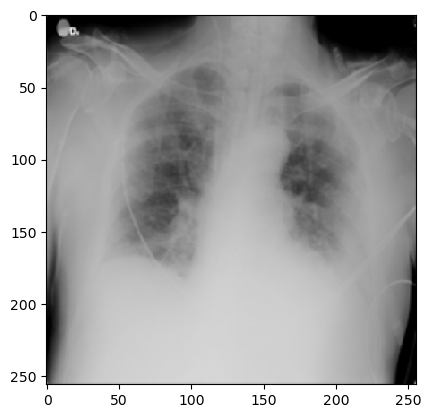

In [9]:
image_file_name = train_dir + '/COVID/COVID-1.png'
img = image.load_img(image_file_name, target_size=(256, 256))
plt.imshow(img)

Тестуємо генератор. Виведемо перші 4 зображення із згенерованого батчу.

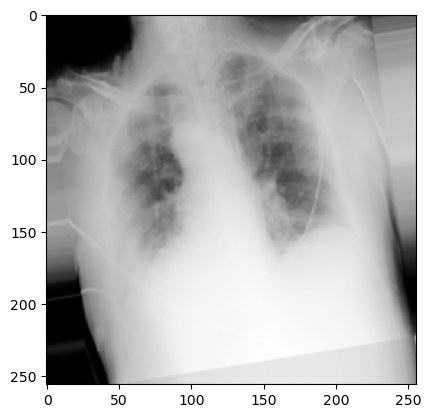

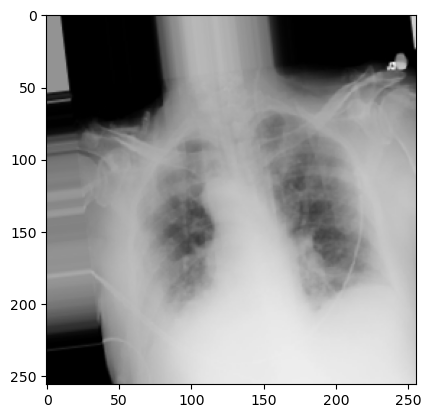

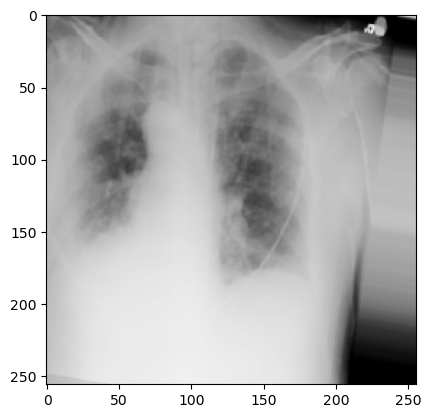

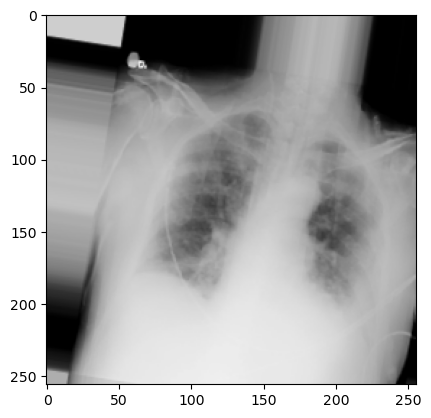

In [10]:
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

Після того, як навчальні дані підготовлені, можна створити модель нейронної мережі.

In [11]:
# Створюємо послідовну модель
model = Sequential()

# Згортковий прошарок
model.add(Conv2D(32, (5, 5), padding='same', input_shape=input_shape, activation='relu'))
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Згортковий прошарок
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# Згортковий прошарок
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Згортковий прошарок
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# Згортковий прошарок
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Згортковий прошарок
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Повнозв'язна частина нейронної мережі для класифікації
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))

# Вихідний прошарок, 8 нейронів (за кількістю класів)
model.add(Dense(4, activation="softmax"))

# Компілюємо модель. В якості оптимізатора вказуємо Adam з модифікованим значенням швидкості навчання
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

Навчаємо описану нейронну мережу. У методі `fit()` вказуємо наступні атрибути:

- `train_generator` - посилання на об'єкт-генератор навчальних даних;
- `steps_per_epoch = 40` - кількість батчів за одну епоху. Повинна приблизно дорівнювати (кількість картинок в навчальному каталозі / розмір батчу);
- `epochs=150` - кількість епох, визначається емпірично;
- `validation_data=val_generator` - посилання на об'єкт-генератор даних для валідації;
- `validation_steps= 10` - кількість батчів за одну епоху. Повинна приблизно дорівнювати (кількість картинок в каталозі для валідації / розмір батчу).

In [12]:
history = model.fit(
            train_generator,
            steps_per_epoch = 32,
            epochs=150,
            validation_data=val_generator,
            validation_steps= 10)

Epoch 1/150
32/32 [==============================] - 171s 5s/step - loss: 11.2413 - accuracy: 0.3896 - val_loss: 11.0397 - val_accuracy: 0.4250
Epoch 2/150
32/32 [==============================] - 166s 5s/step - loss: 10.7559 - accuracy: 0.4375 - val_loss: 10.6148 - val_accuracy: 0.4250
Epoch 3/150
32/32 [==============================] - 159s 5s/step - loss: 10.3084 - accuracy: 0.4463 - val_loss: 10.2041 - val_accuracy: 0.3469
Epoch 4/150
32/32 [==============================] - 158s 5s/step - loss: 9.8929 - accuracy: 0.4639 - val_loss: 9.7975 - val_accuracy: 0.3750
Epoch 5/150
32/32 [==============================] - 157s 5s/step - loss: 9.5033 - accuracy: 0.4697 - val_loss: 9.4194 - val_accuracy: 0.4187
Epoch 6/150
32/32 [==============================] - 157s 5s/step - loss: 9.1696 - accuracy: 0.4424 - val_loss: 9.0774 - val_accuracy: 0.3844
Epoch 7/150
32/32 [==============================] - 158s 5s/step - loss: 8.7744 - accuracy: 0.4912 - val_loss: 8.7377 - val_accuracy: 0.4281


32/32 [==============================] - 240s 7s/step - loss: 3.0864 - accuracy: 0.5615 - val_loss: 3.2051 - val_accuracy: 0.5500
Epoch 59/150
32/32 [==============================] - 229s 7s/step - loss: 3.0915 - accuracy: 0.5537 - val_loss: 3.2027 - val_accuracy: 0.5094
Epoch 60/150
32/32 [==============================] - 213s 7s/step - loss: 3.0640 - accuracy: 0.5635 - val_loss: 3.1609 - val_accuracy: 0.4906
Epoch 61/150
32/32 [==============================] - 197s 6s/step - loss: 3.0419 - accuracy: 0.5576 - val_loss: 3.1325 - val_accuracy: 0.5031
Epoch 62/150
32/32 [==============================] - 194s 6s/step - loss: 2.9754 - accuracy: 0.5625 - val_loss: 3.0718 - val_accuracy: 0.5344
Epoch 63/150
32/32 [==============================] - 220s 7s/step - loss: 2.9514 - accuracy: 0.5771 - val_loss: 3.0404 - val_accuracy: 0.5219
Epoch 64/150
32/32 [==============================] - 216s 7s/step - loss: 2.9119 - accuracy: 0.5752 - val_loss: 3.0187 - val_accuracy: 0.5437
Epoch 65/150

32/32 [==============================] - 206s 6s/step - loss: 1.9652 - accuracy: 0.5996 - val_loss: 2.0608 - val_accuracy: 0.5031
Epoch 116/150
32/32 [==============================] - 208s 7s/step - loss: 1.9154 - accuracy: 0.6201 - val_loss: 2.0442 - val_accuracy: 0.5156
Epoch 117/150
32/32 [==============================] - 206s 6s/step - loss: 1.9706 - accuracy: 0.5859 - val_loss: 2.0351 - val_accuracy: 0.5063
Epoch 118/150
32/32 [==============================] - 207s 6s/step - loss: 1.9056 - accuracy: 0.6133 - val_loss: 2.0863 - val_accuracy: 0.4906
Epoch 119/150
32/32 [==============================] - 215s 7s/step - loss: 1.9329 - accuracy: 0.5693 - val_loss: 2.0241 - val_accuracy: 0.5219
Epoch 120/150
32/32 [==============================] - 207s 6s/step - loss: 1.8737 - accuracy: 0.6221 - val_loss: 2.0336 - val_accuracy: 0.5156
Epoch 121/150
32/32 [==============================] - 207s 6s/step - loss: 1.8856 - accuracy: 0.6035 - val_loss: 1.9755 - val_accuracy: 0.5312
Epoch 

Побудуємо графік навчання.

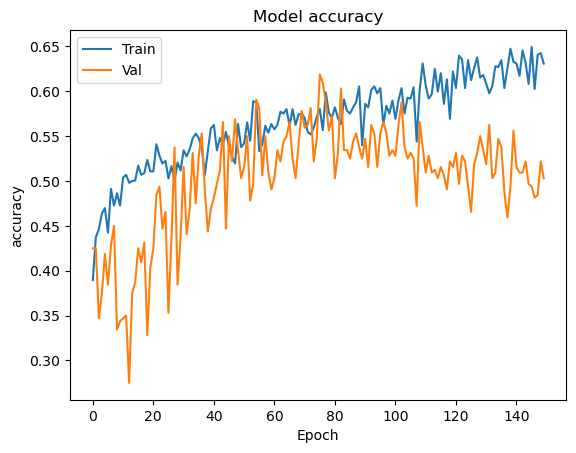

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Перенавчання немає. Проведемо оцінку якості роботи мережі на тестовій множині, вказавши у методі `evaluate()` посилання на генератор даних для тестування.

In [14]:
scores = model.evaluate(test_generator)
print(f"Доля правильних відповідей на тестових даних: {(scores[1]*100):.2f}")

44/44 [==============================] - 73s 2s/step - loss: 1.8003 - accuracy: 0.4996
Доля правильних відповідей на тестових даних: 49.96


Як бачимо, мережа демонструє не найкращі показники на тестовій множині. Для покращення результатів необхідно використовувати більш складну архітектуру мережі.

Застосуємо навчену мережу для розпізнавання довільного зображення.

In [15]:
from IPython.display import Image
from tkinter.filedialog import askopenfilename

(-0.5, 255.5, 255.5, -0.5)

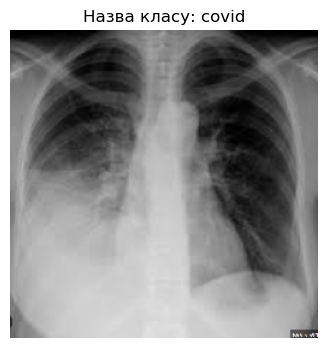

In [17]:
# Викликаємо віконце для вибору файлу
img_path = askopenfilename()

# Імпортуємо зображення та масштабуємо його (img_path, ширина=256, висота=256)
img = image.load_img(img_path, target_size=(256, 256))

# Перетворюємо зображення в масив
x = image.img_to_array(img)
x = x.reshape(-1, 256, 256, 3)

# Подаємо зображення на вхід мережі для класифікації
prediction = model.predict(x)

# Визначаємо код класу
prediction = np.argmax(prediction)

# Показуємо результат
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Назва класу: {classes[prediction]}" )
plt.axis("off")